# Voter model - projected network
In this notebook, we run our configuration of the voter model on a projected network. The network was projcted from bipartite into "flat" projected networl. We ran $m=50$ independent realizations of the voter model, each realizaton has $10^6$ repeats. We ploted the number of changes per number of repeats (how many nodes fliped / changed the state), so we can see how the process evolve over the time. In order to validate the model, we chose 3/10-_ths_ as a testing set, run the model, based on values which the model assigned to the training data, we determined the confusion matrix, ROC curve and total accuracy. 

In [1]:
import voter_model as vm
from kassiopea import Kassiopea
from tools import plot_roc, plot_pdf, round_acc, round_acc2

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import random as r
import time
import csv

In [2]:
start = time.time()
# Create a network as an object of lib kassiopeia 
K = Kassiopea()

# Statistics of initial states counts
blacklisted = 0
whitelisted = 0
uknown = 0

# Add network's nodes and edges from file
with open("data/data.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Create domain's nodes
        if row["domain"] not in K.get_nodes():
            label = int(row["domain_state"])
            if label == 0:
                zea = 1
                uknown += 1
            else:
                zea = 0
                if label == 1:
                    whitelisted += 1
                else:
                    blacklisted += 1
                    
            K.add_node(row["domain"], zea=zea, label=label)
        
        # Create ip's nodes 
        if row["ip"] not in K.get_nodes():
            label = int(row["ip_state"])
            if label == 0:
                zea = 1
                uknown += 1
            else:
                zea = 0
                if label == 1:
                    whitelisted += 1
                else:
                    blacklisted += 1
    
            K.add_node(row["ip"], zea=zea, label=label)
        
        # Create an edge between IP <-> Domain
        K.add_edge(row["domain"], row["ip"])
        
print(f"Network is created in: {round(time.time() - start, 3)}s")

Network is created in: 503.752s


As the network is created, nodes and edges are added we can run realisations of Voter Model.

In [3]:
# As the original labels and zeas will be changed, we deepcopy them 
original_labels = deepcopy(K.label)
original_zeas = deepcopy(K.zea)

# Selecting the zeas from the dataset
zeas = [i for i, v in enumerate(original_zeas) if v == 0]
num_zeas = len(zeas)

In [4]:
# Bipartie projection 
start = time.time()
K.projection()
print(f"Network is projected in: {round(time.time() - start, 3)}s")

Network is projected in: 35.174s


In [5]:
# Statistics of final states counts
blacklisted_f = 0
whitelisted_f = 0
uknown_f = 0
    
rate = {}
num_nodes = len(K.get_nodes())
stopping_time = []

# Num of realisation of Voter Model
m = 50

# Fraction size of the trainning data set
accs = 3 / 10
num_ch = int(num_zeas * accs)
random_z = r.sample(zeas, num_ch)

# Set the lables to original labels
K.update_label(original_labels)
K.update_zea(original_zeas)

# Trainning zeas are labeled as unknown
for n in random_z:
    K.update_zea_node(n, 1)
    K.update_label_node(n, 0)

# Deepcopy current labels with trainning zeas
labels = deepcopy(K.label)
rate = [0] * num_nodes   
hists = {}

# Running m independent realisation of Voter Model
for i in range(m):
    # Set the labels to original ones
    K.update_label(labels)
    stop = time.time()
    hist, x, st, u = vm.voter_model_realisation(K, 6, 0.01)
    hists[i] = hist
    print(f"Time used for this realization {round(time.time() - stop, 3)}s, realization: {i + 1} / {m}")
    
    # Assign rate for later computing of longterm average
    for n in range(num_nodes):
        rate[n] += int(K.label[n])

Time used for this realization 6.093s, realization: 1 / 50
Time used for this realization 6.894s, realization: 2 / 50
Time used for this realization 6.622s, realization: 3 / 50
Time used for this realization 6.155s, realization: 4 / 50
Time used for this realization 6.335s, realization: 5 / 50
Time used for this realization 6.351s, realization: 6 / 50
Time used for this realization 6.269s, realization: 7 / 50
Time used for this realization 5.712s, realization: 8 / 50
Time used for this realization 6.009s, realization: 9 / 50
Time used for this realization 5.971s, realization: 10 / 50
Time used for this realization 7.563s, realization: 11 / 50
Time used for this realization 6.286s, realization: 12 / 50
Time used for this realization 6.24s, realization: 13 / 50
Time used for this realization 7.203s, realization: 14 / 50
Time used for this realization 6.576s, realization: 15 / 50
Time used for this realization 5.685s, realization: 16 / 50
Time used for this realization 6.112s, realization

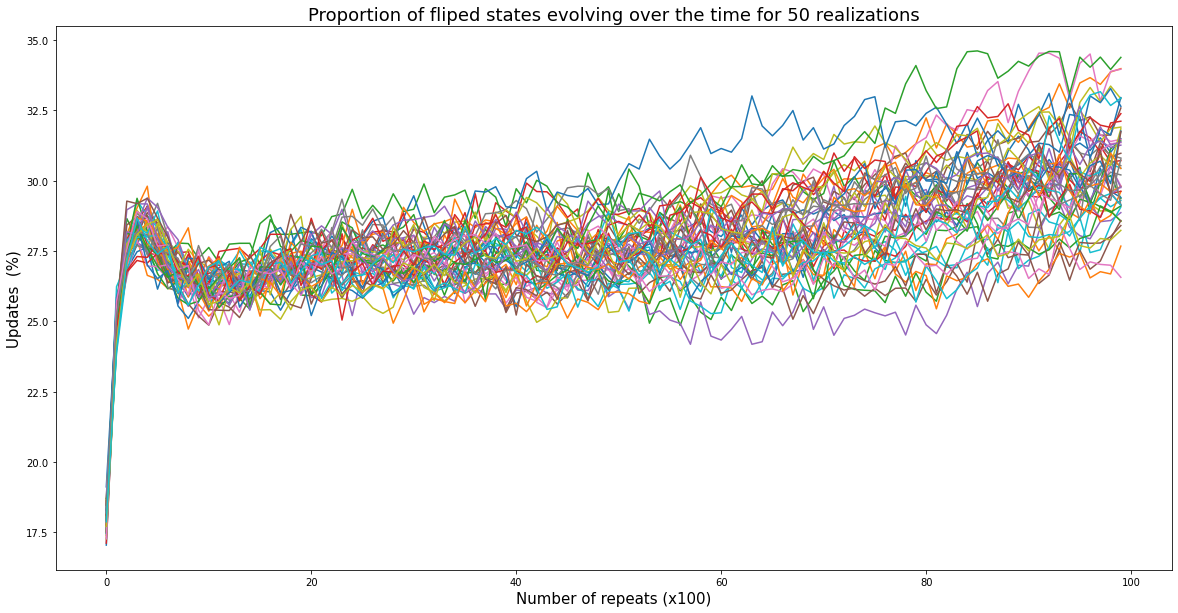

In [6]:
plt.figure(figsize=(20, 10))
plt.title(f"Proportion of fliped states evolving over the time for {m} realizations", fontsize=18)
plt.xlabel("Number of repeats (x100)", fontsize=15)
plt.ylabel("Updates  (%)", fontsize=15)
lenght = len(hists)
last = [0] * lenght
for i in range(lenght):
    plt.plot(np.array(hists[i][:])*100)

plt.show()

After m realisations are run we can make some statistics and take a look on accuracy. Under confustion matrix we understand: 

$$\begin{bmatrix}
    TrueWhitelisted & FlaseWhitelisted \\
    FalseBlacklisted & TrueBlacklisted \\
\end{bmatrix}$$

In [7]:
# Confusion matrix
confusion_matrix = np.zeros((2, 2))

def round_1(x):
    if x < 0:
        return -1
    elif x > 0:
        return 1
    else:
        return 0
    

for n in random_z: 
    if original_labels[n] == round_1(rate[n]):
        if original_labels[n] == 1:
            confusion_matrix[0][0] +=1
        else:
            confusion_matrix[1][1] +=1
    else:
        if original_labels[n] == 1:
            confusion_matrix[0][1] +=1
        else:
            confusion_matrix[1][0] +=1
            
print("Confusion matrix, relative numbers")  
print(confusion_matrix[0] / (confusion_matrix[0][1] + confusion_matrix[0][0]))
print(confusion_matrix[1] / (confusion_matrix[1][1] + confusion_matrix[1][0]), "\n")

print("Confusion matrix, absolute numbers")
print(confusion_matrix)
print("Accuracy:", (confusion_matrix[0][0] + confusion_matrix[1][1]) / len(random_z), "\n")

blacklisted_f = 0
whitelisted_f = 0
uknown_f = 0

for n in range(num_nodes):
    if (rate[n] / m) < 0:
        blacklisted_f += 1
    elif (rate[n] / m) > 0:
        whitelisted_f += 1
    else:
        uknown_f += 1

# Statistics about states
print(f"#Uknown: (before, after)", (uknown_f, uknown))
print(f"#Whitelisted: (before, after)", (whitelisted_f, whitelisted))
print(f"#Blacklisted: (before, after)", (blacklisted_f, blacklisted), "\n")
      
print(f"Ratio whitelisted/blacklisted in the end: {whitelisted_f / blacklisted_f}")
print(f"Ratio whitelisted/blacklisted in the beginning: {whitelisted / blacklisted}")
print(f"#nodes: {len(K.get_nodes())}")
print(f"#edges: {len(K.get_edges())}")

Confusion matrix, relative numbers
[0.26732673 0.73267327]
[0.04260985 0.95739015] 

Confusion matrix, absolute numbers
[[ 54. 148.]
 [ 32. 719.]]
Accuracy: 0.8111227701993704 

#Uknown: (before, after) (27786, 93674)
#Whitelisted: (before, after) (12851, 643)
#Blacklisted: (before, after) (56216, 2536) 

Ratio whitelisted/blacklisted in the end: 0.228600398463071
Ratio whitelisted/blacklisted in the beginning: 0.2535488958990536
#nodes: 96853
#edges: 36127052


In this section, we would like to present ROC curve and comparison between rate, eigenvalue centrality, degree distibution

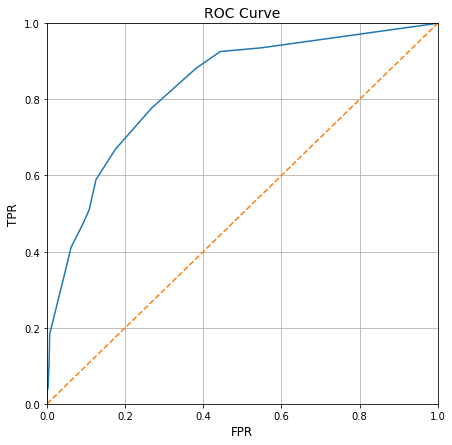

In [8]:
l = 20 
wl = [(rate[n] / m) for n in random_z if original_labels[n] == 1]
bl = [(rate[n] / m) for n in random_z if original_labels[n] == -1]

hist_wl,bins=np.histogram(wl, bins=np.linspace(-1, 1, l + 1), density=True)
hist_bl,bins=np.histogram(bl, bins=np.linspace(-1, 1, l + 1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plot_roc(hist_bl,hist_wl, ax, np.arange(0, l))
plt.show()

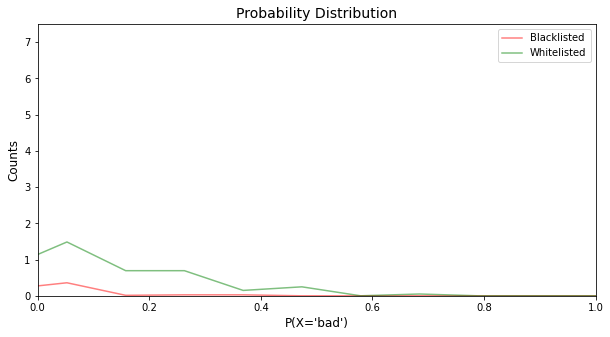

In [9]:
x = np.linspace(-1, 1, num=l)
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(hist_bl, hist_wl, ax, x)
plt.show()

### Sources:
[1] Receiver Operating Characteristic Curves Demystified (in Python), https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0